# How To Export a Model Trained in Supervisely

After you have trained a model using Supervisely application, you can download its weights and config file, and use the model outside Supervisely Platform.

## 1. Download model weights and config from Team Files

**1. Go to Team Files:**

![Team Files](https://github.com/supervisely-ecosystem/mmsegmentation/assets/31512713/678fbf96-e16c-449d-9e5d-1ae4efc8a796)

**2. Download model weights:**

![Download model](https://github.com/supervisely-ecosystem/unet/assets/31512713/e748110d-4852-4731-b27c-3b1f0b9b7b3d)

**3. Download these meta files:**

![Download files](https://github.com/supervisely-ecosystem/unet/assets/31512713/b156feb6-b93e-4f0b-90cd-9955067474df)

**Alternatively, you can download these files using Supervisely API:**

In [ ]:
# Install supervisely SDK if not installed
!pip install supervisely

In [ ]:
# Fill in these arguments:
server_address = "https://..."
api_token = "abcd0123456789..."
team_id = ...
path_to_weights_in_team_files = ...
path_to_model_classes_in_team_files = ...
path_to_ui_state_in_team_files = ...
download_dir = "./my_model"

import supervisely as sly
api = sly.Api(server_address, api_token)
api.file.download(team_id, path_to_weights_in_team_files, f"{download_dir}/weights.pth")
api.file.download(team_id, path_to_model_classes_in_team_files, f"{download_dir}/model_classes.json")
api.file.download(team_id, path_to_ui_state_in_team_files, f"{download_dir}/ui_state.json")

## 2. Install requirements

**You can use our pre-builded docker image.**

**Docker:** `supervisely/unet:1.0.2`

Or build the image with this [Dockerfile](https://github.com/supervisely-ecosystem/unet/blob/master/docker/Dockerfile).

**Alternatively, you can install needed requirements manually with pip:**

In [ ]:
!pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 -f https://download.pytorch.org/whl/torch_stable.html
!pip install opencv-python==4.5.5.64
!pip install matplotlib

## 3. Build the model

After you've installed requirements and downloaded model weights and config, **fill in the paths** where the files located:

In [ ]:
# Put your paths here:
weights_path = "my_model/weights.pth"
model_classes_path = "my_model/model_classes.json"
ui_state_path = "my_model/ui_state.json"

device = "cuda:0"

Below we define a helpful class to make inference easier:

In [14]:
import cv2
import torch
from torchvision import transforms

import custom_net.models as unet_models


class UNetInference:
    def __init__(self, model_classes, ui_state, device):
        self.transforms_img = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),  # imagenet
        ])
        self.model_classes = model_classes
        self.ui_state = ui_state
        self.device = device

        self.model_name = self.ui_state["selectedModel"]
        self.input_width = self.ui_state["imgSize"]["width"]
        self.input_height = self.ui_state["imgSize"]["height"]

    def load_weights(self, weights_path):
        num_classes = len(self.model_classes)
        model_class = getattr(unet_models, self.model_name)
        model = model_class(num_classes=num_classes)
        state = torch.load(weights_path, map_location=self.device)
        model.load_state_dict(state)
        model.to(self.device)
        model.eval()
        self.model = model

    def predict(self, image_path):
        image = cv2.imread(image_path)  # RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        input = self.prepare_image_input(image, self.device)
        with torch.no_grad():
            output = self.model(input)
        image_height, image_width = image.shape[:2]
        predicted_classes_indices = output.data.cpu().numpy().argmax(axis=1)[0]
        result = cv2.resize(predicted_classes_indices, (image_width, image_height), interpolation=cv2.INTER_NEAREST)
        return result

    def prepare_image_input(self, image, device):
        # RGB -> Normalized Tensor
        input = cv2.resize(image, (self.input_width, self.input_height))
        input = self.transforms_img(input)  # totensor + normalize
        input = torch.unsqueeze(input, 0)
        input = input.to(device)
        return input

In [37]:
import json

def load_json(file_json):
    with open(file_json, "r") as f:
        return json.load(f)
    
ui_state = load_json(ui_state_path)
model_classes = load_json(model_classes_path)

model = UNetInference(model_classes, ui_state, device)
model.load_weights(weights_path)

## 4. Inference

In [18]:
image_path = "supervisely/serve/demo/lemons.jpg"
result = model.predict(image_path)
result

array([[2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       ...,
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2]], dtype=int32)

## 5. Visualize

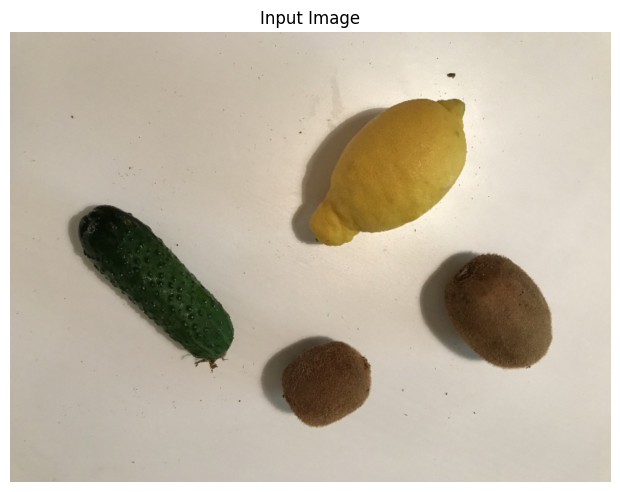

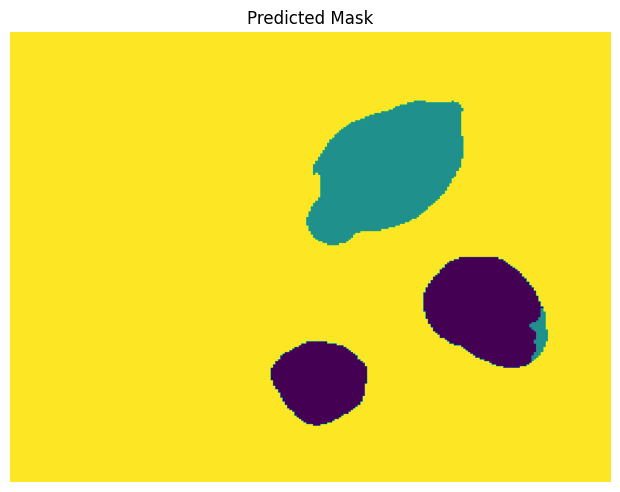

In [35]:
from matplotlib import pyplot as plt


def imshow(img, name):
    plt.imshow(img)
    plt.axis("off")
    plt.tight_layout()
    plt.title(name)
    plt.show()

img = cv2.imread(image_path)[...,::-1]
imshow(img, "Input Image")
imshow(result, "Predicted Mask")